In [1]:
# import collections
import numpy as np
import pandas as pd
import re
# import joblib
from pathlib import Path
# import scipy
from openpyxl import load_workbook
# from matplotlib.patches import Rectangle

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

file_rev = Path('processed_REV_human.xlsx')
file_plev = Path('processed_PLEV_human.xlsx')

/home/tin/.local/lib/python3.9/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


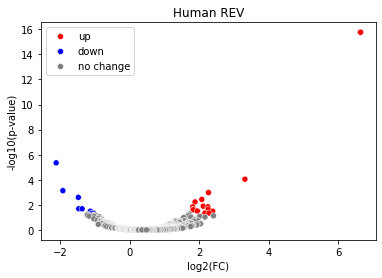

In [2]:
# make volcano plot

# # REV
sheet_name = 'Proteins'
df = pd.read_excel(file_rev, sheet_name=sheet_name)

# # read the file
# sheet_name = 'All Proteins'
# df = pd.read_excel(file_rev, sheet_name=sheet_name)

# get the column names
columns_anemic = [x for x in df.columns if re.search(r'^Abundances\s\(Normalized\)', x) and re.search(r'Anemia', x)]
columns_CAD = [x for x in df.columns if re.search(r'^Abundances\s\(Normalized\)', x) and re.search(r'CAD', x)]
tmpdf_anemic = df[columns_anemic].copy()
tmpdf_anemic.fillna(0, inplace=True)
tmpdf_CAD = df[columns_CAD].copy()
tmpdf_CAD.fillna(0, inplace=True)

# keep proteins with at least 5 counts in either condition
# indices_anemic, = np.where(tmpdf_anemic.values.sum(axis=1) > 4.5)
# indices_CAD, = np.where(tmpdf_CAD.values.sum(axis=1) > 4.5)
indices_anemic, = np.where((tmpdf_anemic.values>0).sum(axis=1) > 4.5)
indices_CAD, = np.where((tmpdf_CAD.values>0).sum(axis=1) > 4.5)

indices_considered = sorted(np.union1d(indices_anemic, indices_CAD))
df_union = df.iloc[indices_considered, :]

# indices_intersected = sorted(np.intersect1d(indices_anemic, indices_CAD))
# df_intersection = df.iloc[indices_intersected, :]

# print(df.shape[0], df_union.shape[0], df_intersection.shape[0])
# # 2389 2369 2366

# make volcano plot
tmpdf = df_union.loc[:,['Gene Symbol', 'Abundance Ratio: (Anemia) / (CAD)', 'Abundance Ratio Adj. P-Value: (Anemia) / (CAD)']]
tmpdf.columns = ['Name', 'Fold Change', 'p-value']
iii_up = tmpdf[(tmpdf['Fold Change']>=1) & (tmpdf['p-value']<0.05)].index.tolist()
iii_down = tmpdf[(tmpdf['Fold Change']<=1) & (tmpdf['p-value']<0.05)].index.tolist()
iii_noChange = tmpdf[tmpdf['p-value']>=0.05].index.tolist()
tmpdf['Colour'] = ''
tmpdf.loc[iii_up, 'Colour'] = 'up'
tmpdf.loc[iii_down, 'Colour'] = 'down'
tmpdf.loc[iii_noChange, 'Colour'] = 'no change'
tmpdf['-log10(p-value)'] = -np.log10(tmpdf['p-value'])
tmpdf['log2(FC)'] = np.log2(tmpdf['Fold Change'])
# tmpdf_b = tmpdf[(tmpdf['p-value'] < 0.05) & (tmpdf['Fold Change'] > 2)]

plt.clf()
sns.scatterplot(data=tmpdf, x='log2(FC)', y='-log10(p-value)', hue='Colour', palette={'up':'red', 'down':'blue', 'no change':'grey'}).legend(title='')
# plt.axhline(y=-np.log10(0.05), color='black', linestyle='--')
# plt.axvline(x=1, color='black', linestyle='--')
# plt.axvline(x=-1, color='black', linestyle='--')
plt.title('Human REV')
plt.show()

fig = px.scatter(
    tmpdf,
    x='log2(FC)',
    y='-log10(p-value)',
    color='Colour',
    color_discrete_map={'up': 'red', 'down': 'blue', 'no change': 'grey'},
    hover_data=['Name'],
    title='PLEV'
)
fig.add_hline(y=-np.log10(0.05), line_dash="dash", line_color="black")
fig.add_vline(x=1, line_dash="dash", line_color="black")
fig.add_vline(x=-1, line_dash="dash", line_color="black")
fig.show()
fig.write_html('volcano_human_REV.html')

/home/tin/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:395: RuntimeWarning:

divide by zero encountered in log10



<Figure size 432x288 with 0 Axes>

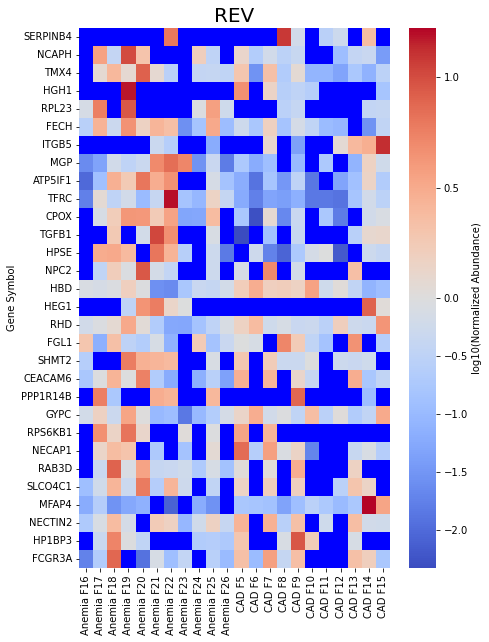

In [3]:
# make heatmap, differentially expressed, REV
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import TwoSlopeNorm 
# from matplotlib.patches import Rectangle

tmpsheet = 'Differentially expressed'

df = pd.read_excel(file_rev, sheet_name=tmpsheet)
df = df.sort_values(by='Abundance Ratio: (Anemia) / (CAD)', ascending=False)

# get the column names
columns_anemic = [x for x in df.columns if re.search(r'^Abundances\s\(Normalized\)', x) and re.search(r'Anemia', x)]
columns_CAD = [x for x in df.columns if re.search(r'^Abundances\s\(Normalized\)', x) and re.search(r'CAD', x)]
tmpdf_anemic = df[columns_anemic].copy()
tmpdf_anemic.fillna(0, inplace=True)
tmpdf_CAD = df[columns_CAD].copy()
tmpdf_CAD.fillna(0, inplace=True)

# keep proteins with at least 5 counts in either condition
# indices_anemic, = np.where(tmpdf_anemic.values.sum(axis=1) > 4.5)
# indices_CAD, = np.where(tmpdf_CAD.values.sum(axis=1) > 4.5)
indices_anemic, = np.where((tmpdf_anemic.values>0).sum(axis=1) > 4.5)
indices_CAD, = np.where((tmpdf_CAD.values>0).sum(axis=1) > 4.5)

indices_considered = sorted(np.union1d(indices_anemic, indices_CAD))
df_union = df.iloc[indices_considered, :]

# prepare the data frame for heatmap
tmpdf = df_union[columns_anemic + columns_CAD].copy()
tmpdf.fillna(0, inplace=True)
tmpdf.index = df_union['Gene Symbol']
tmpdf = (tmpdf.T / np.nanmean(tmpdf.values, axis=1)).T
tmp_colnames = []
for x in tmpdf.columns:    
    if re.search(r'Anemia$', x):
        txt_condition = 'Anemia'
    elif re.search(r'CAD$', x):
        txt_condition = 'CAD'
    else:
        txt_condition = ''
        print('Error', x)
    match = re.search(r'\bF\d+\b', x)
    if match:
        txt_F = match.group(0)
    else:
        txt_F = ''
        print('Error FFF', x)
    tmp_colnames.append(f'{txt_condition} {txt_F}')
tmpdf.columns = tmp_colnames
tmpdf = np.log10(tmpdf)
tmpdf[np.isinf(tmpdf)] = np.nan

# find out the max and min values in the heatmap
tmpv = tmpdf.values.reshape(-1)
vmin = tmpv[np.isfinite(tmpv)].min()
vmax = tmpv[np.isfinite(tmpv)].max()

# Create a TwoSlopeNorm instance with the midpoint
midpoint = 0
norm = TwoSlopeNorm(vmin=vmin, vcenter=midpoint, vmax=vmax)

# simple heatmap plot
plt.clf()
plt.figure(figsize=(9, 15))
cmap = sns.color_palette("coolwarm", as_cmap=True)
cmap.set_bad(color='blue')
heatmap = sns.heatmap(tmpdf, cmap=cmap, norm=norm)
cbar = heatmap.collections[0].colorbar
cbar.set_label('log10(Normalized Abundance)')
plt.title('REV', fontsize=20)
plt.subplots_adjust(left=0.2, right=0.8, top=0.9, bottom=0.4)
plt.show()

<Figure size 432x288 with 0 Axes>

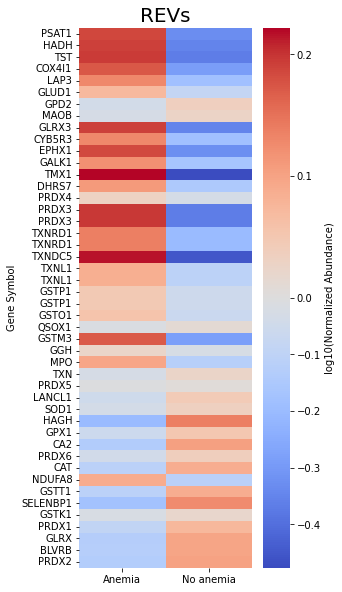

In [4]:
# make heatmap, redox, REV
from matplotlib.colors import TwoSlopeNorm 

tmpsheet = 'Sorted redox proteins'

df = pd.read_excel(file_rev, sheet_name=tmpsheet)
workbook = load_workbook(file_rev)
sheet = workbook[tmpsheet]
first_column_colors = []
for row in range(1, sheet.max_row + 1):  # Iterate over all rows
    cell = sheet.cell(row=row, column=1)  # First column is column 1
    cell_color = cell.fill.start_color.index  # Get the color in ARGB format
    first_column_colors.append(cell_color)
hash_gene2color = {x:first_column_colors[i+1] for i,x in enumerate(df['Gene Symbol'])}

df = df.sort_values(by='Abundance Ratio: (Anemia) / (CAD)', ascending=False)

# get the column names
columns_anemic = [x for x in df.columns if re.search(r'^Abundances\s\(Normalized\)', x) and re.search(r'Anemia', x)]
columns_CAD = [x for x in df.columns if re.search(r'^Abundances\s\(Normalized\)', x) and re.search(r'CAD', x)]
tmpdf_anemic = df[columns_anemic].copy()
tmpdf_anemic.fillna(0, inplace=True)
tmpdf_CAD = df[columns_CAD].copy()
tmpdf_CAD.fillna(0, inplace=True)

# keep proteins with at least 5 counts in either condition
# indices_anemic, = np.where(tmpdf_anemic.values.sum(axis=1) > 4.5)
# indices_CAD, = np.where(tmpdf_CAD.values.sum(axis=1) > 4.5)
indices_anemic, = np.where((tmpdf_anemic.values>0).sum(axis=1) > 4.5)
indices_CAD, = np.where((tmpdf_CAD.values>0).sum(axis=1) > 4.5)

indices_considered = sorted(np.union1d(indices_anemic, indices_CAD))
df_union = df.iloc[indices_considered, :]

# prepare the data frame for heatmap
arr_anemic = [x for x in df.columns if re.search(r'^Abundances\s\(Grouped\)', x) and re.search(r'Anemia', x)]
arr_CAD = [x for x in df.columns if re.search(r'^Abundances\s\(Grouped\)', x) and re.search(r'CAD', x)]
tmpdf = df_union[arr_anemic + arr_CAD].copy()
tmpdf.fillna(0, inplace=True)
tmpdf.index = df_union['Gene Symbol']
tmpdf = (tmpdf.T / np.nanmean(tmpdf.values, axis=1)).T
tmpaa = [x.split()[-1] for x in tmpdf.columns]
tmpdf.columns = tmpaa
tmpdf = np.log10(tmpdf)
tmpdf[np.isinf(tmpdf)] = np.nan
tmpdf.columns = ['Anemia', 'No anemia']

# find out the max and min values in the heatmap
tmpv = tmpdf.values.reshape(-1)
vmin = tmpv[np.isfinite(tmpv)].min()
vmax = tmpv[np.isfinite(tmpv)].max()

# Create a TwoSlopeNorm instance with the midpoint
midpoint = 0
norm = TwoSlopeNorm(vmin=vmin, vcenter=midpoint, vmax=vmax)
gene_color0s = ['#'+hash_gene2color[x][2:] for x in tmpdf.index]
tmparr_color0 = list(set(gene_color0s))
tmparr_color = ['blue', 'grey', 'red', 'green']
hash_color02gene = {x:y for x,y in zip(tmparr_color0, tmparr_color)}
# gene_colors = [hash_color02gene[x] for x in gene_color0s]

plt.clf()
fig, ax = plt.subplots(figsize=(5, 15))
cmap = sns.color_palette("coolwarm", as_cmap=True)
cmap.set_bad(color='blue')
heatmap = sns.heatmap(tmpdf, cmap=cmap, norm=norm)
# for i, label in enumerate(ax.get_yticklabels()):
#     label.set_color(gene_colors[i])
cbar = heatmap.collections[0].colorbar
cbar.set_label('log10(Normalized Abundance)')
plt.title('REVs', fontsize=20)
plt.subplots_adjust(left=0.2, right=0.8, top=0.9, bottom=0.4)
plt.show()

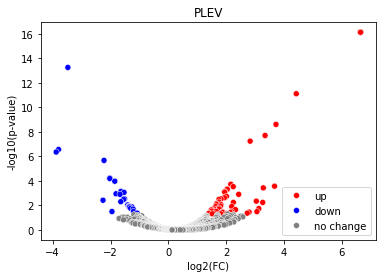

In [5]:
# make volcano plot

# PLEV
# tmpsheet = 'Proteins'
# df = pd.read_excel(file_plev0, sheet_name=tmpsheet)

tmpsheet = 'All Proteins_Human'
df = pd.read_excel(file_plev, sheet_name=tmpsheet)

# get the column names
columns_anemic = [x for x in df.columns if re.search(r'^Abundances\s\(Normalized\)', x) and re.search(r'Anemia', x)]
columns_CAD = [x for x in df.columns if re.search(r'^Abundances\s\(Normalized\)', x) and re.search(r'CAD', x)]
tmpdf_anemic = df[columns_anemic].copy()
tmpdf_anemic.fillna(0, inplace=True)
tmpdf_CAD = df[columns_CAD].copy()
tmpdf_CAD.fillna(0, inplace=True)

# keep proteins with at least 5 counts in either condition
# indices_anemic, = np.where(tmpdf_anemic.values.sum(axis=1) > 4.5)
# indices_CAD, = np.where(tmpdf_CAD.values.sum(axis=1) > 4.5)
indices_anemic, = np.where((tmpdf_anemic.values>0).sum(axis=1) > 4.5)
indices_CAD, = np.where((tmpdf_CAD.values>0).sum(axis=1) > 4.5)

indices_considered = sorted(np.union1d(indices_anemic, indices_CAD))
df_union = df.iloc[indices_considered, :]

# print(df.shape[0], df_union.shape[0], df_intersection.shape[0])
# # 2071 2071 2044

# make volcano plot
tmpdf = df_union.loc[:,['Gene Symbol', 'Abundance Ratio: (Anemia) / (CAD)', 'Abundance Ratio Adj. P-Value: (Anemia) / (CAD)']]
tmpdf.columns = ['Name', 'Fold Change', 'p-value']
iii_up = tmpdf[(tmpdf['Fold Change']>=1) & (tmpdf['p-value']<0.05)].index.tolist()
iii_down = tmpdf[(tmpdf['Fold Change']<=1) & (tmpdf['p-value']<0.05)].index.tolist()
iii_noChange = tmpdf[tmpdf['p-value']>=0.05].index.tolist()
tmpdf['Colour'] = ''
tmpdf.loc[iii_up, 'Colour'] = 'up'
tmpdf.loc[iii_down, 'Colour'] = 'down'
tmpdf.loc[iii_noChange, 'Colour'] = 'no change'
tmpdf['-log10(p-value)'] = -np.log10(tmpdf['p-value'])
tmpdf['log2(FC)'] = np.log2(tmpdf['Fold Change'])
plt.clf()
sns.scatterplot(data=tmpdf, x='log2(FC)', y='-log10(p-value)', hue='Colour', palette={'up':'red', 'down':'blue', 'no change':'grey'}).legend(title='')
# plt.axhline(y=-np.log10(0.05), color='black', linestyle='--')
# plt.axvline(x=1, color='black', linestyle='--')
# plt.axvline(x=-1, color='black', linestyle='--')
plt.title('PLEV')
plt.show()

fig = px.scatter(
    tmpdf,
    x='log2(FC)',
    y='-log10(p-value)',
    color='Colour',
    color_discrete_map={'up': 'red', 'down': 'blue', 'no change': 'grey'},
    hover_data=['Name'],
    title='PLEV'
)
fig.add_hline(y=-np.log10(0.05), line_dash="dash", line_color="black")
fig.add_vline(x=1, line_dash="dash", line_color="black")
fig.add_vline(x=-1, line_dash="dash", line_color="black")
fig.show()
fig.write_html('volcano_human_PLEV.html')

/home/tin/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:395: RuntimeWarning:

divide by zero encountered in log10



<Figure size 432x288 with 0 Axes>

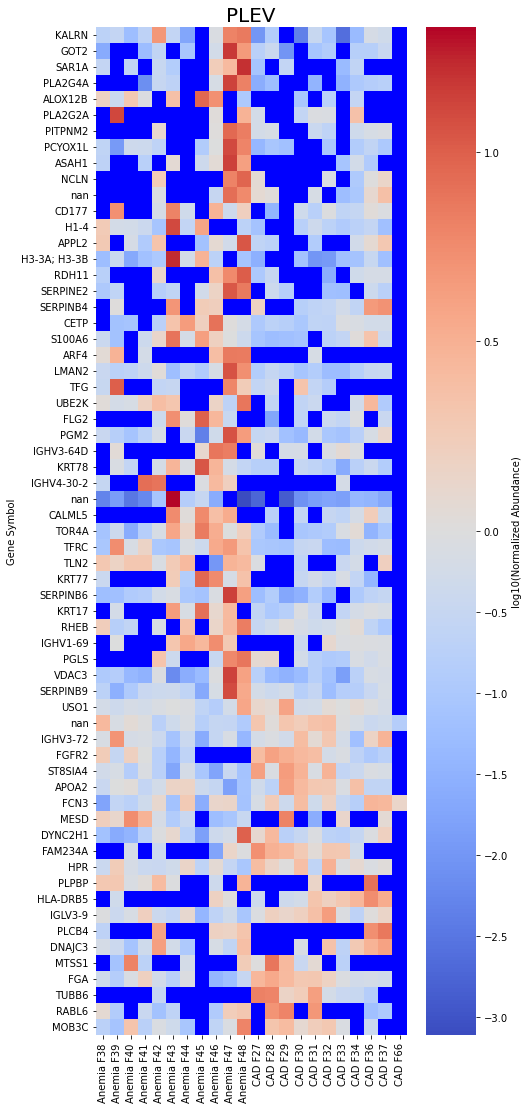

In [6]:
tmpsheet = 'Differentially expressed'

df = pd.read_excel(file_plev, sheet_name=tmpsheet)
df = df.sort_values(by='Abundance Ratio: (Anemia) / (CAD)', ascending=False)

# get the column names
columns_anemic = [x for x in df.columns if re.search(r'^Abundances\s\(Normalized\)', x) and re.search(r'Anemia', x)]
columns_CAD = [x for x in df.columns if re.search(r'^Abundances\s\(Normalized\)', x) and re.search(r'CAD', x)]
tmpdf_anemic = df[columns_anemic].copy()
tmpdf_anemic.fillna(0, inplace=True)
tmpdf_CAD = df[columns_CAD].copy()
tmpdf_CAD.fillna(0, inplace=True)

# keep proteins with at least 5 counts in either condition
# indices_anemic, = np.where(tmpdf_anemic.values.sum(axis=1) > 4.5)
# indices_CAD, = np.where(tmpdf_CAD.values.sum(axis=1) > 4.5)
indices_anemic, = np.where((tmpdf_anemic.values>0).sum(axis=1) > 4.5)
indices_CAD, = np.where((tmpdf_CAD.values>0).sum(axis=1) > 4.5)

indices_considered = sorted(np.union1d(indices_anemic, indices_CAD))
df_union = df.iloc[indices_considered, :]

tmpdf = df_union[columns_anemic + columns_CAD].copy()
tmpdf.fillna(0, inplace=True)
tmpdf.index = df_union['Gene Symbol']
tmpdf = (tmpdf.T / np.nanmean(tmpdf.values, axis=1)).T
tmp_colnames = []
for x in tmpdf.columns:    
    if re.search(r'Anemia$', x):
        txt_condition = 'Anemia'
    elif re.search(r'CAD$', x):
        txt_condition = 'CAD'
    else:
        txt_condition = ''
        print('Error', x)
    match = re.search(r'\bF\d+\b', x)
    if match:
        txt_F = match.group(0)
    else:
        txt_F = ''
        print('Error Fxx', x)
    tmp_colnames.append(f'{txt_condition} {txt_F}')
tmpdf.columns = tmp_colnames
tmpdf = np.log10(tmpdf)
tmpdf[np.isinf(tmpdf)] = np.nan
tmpv = tmpdf.values.reshape(-1)

vmin = tmpv[np.isfinite(tmpv)].min()
vmax = tmpv[np.isfinite(tmpv)].max()
midpoint = 0
# Create a TwoSlopeNorm instance with the midpoint
norm = TwoSlopeNorm(vmin=vmin, vcenter=midpoint, vmax=vmax)

# simple heatmap plot
plt.clf()
plt.figure(figsize=(9, 20))
cmap = sns.color_palette("coolwarm", as_cmap=True)
cmap.set_bad(color='blue')
heatmap = sns.heatmap(tmpdf, cmap=cmap, norm=norm)
cbar = heatmap.collections[0].colorbar
cbar.set_label('log10(Normalized Abundance)')
plt.title('PLEV', fontsize=20)
plt.subplots_adjust(left=0.2, right=0.8, top=0.9, bottom=0.2)
plt.show()

/home/tin/.local/lib/python3.9/site-packages/openpyxl/reader/drawings.py:33: UserWarning:

DrawingML support is incomplete and limited to charts and images only. Shapes and drawings will be lost.



<Figure size 432x288 with 0 Axes>

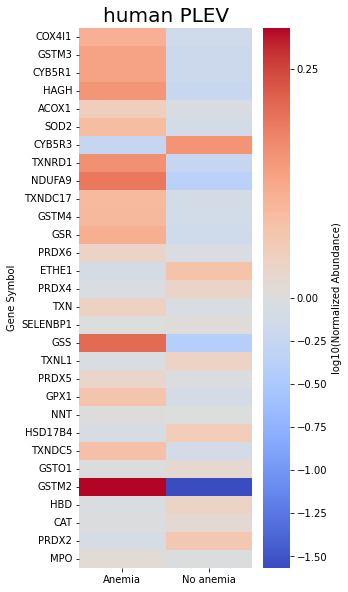

In [7]:
tmpsheet = 'sorted Redox proteins '

df = pd.read_excel(file_plev, sheet_name=tmpsheet)
workbook = load_workbook(file_plev)
sheet = workbook[tmpsheet]
first_column_colors = []
for row in range(1, sheet.max_row + 1):  # Iterate over all rows
    cell = sheet.cell(row=row, column=1)  # First column is column 1
    cell_color = cell.fill.start_color.index  # Get the color in ARGB format
    first_column_colors.append(cell_color)
hash_gene2color = {x:first_column_colors[i+1] for i,x in enumerate(df['Gene Symbol'])}

df = df.sort_values(by='Abundance Ratio: (Anemia) / (CAD)', ascending=False)
arr_anemic = [x for x in df.columns if re.search(r'^Abundances\s\(Normalized\)', x) and re.search(r'Anemia', x)]
arr_CAD = [x for x in df.columns if re.search(r'^Abundances\s\(Normalized\)', x) and re.search(r'CAD', x)]
tmpdf_anemic = df[arr_anemic].copy()
tmpdf_anemic.fillna(0, inplace=True)
tmpdf_CAD = df[arr_CAD].copy()
tmpdf_CAD.fillna(0, inplace=True)
iii_anemic, = np.where(tmpdf_anemic.values.sum(axis=1) > 4.5)
iii_CAD, = np.where(tmpdf_CAD.values.sum(axis=1) > 4.5)

iii_considered = [i for i in sorted(np.union1d(iii_anemic, iii_CAD)) if not pd.isna(df['Gene Symbol'].iat[i])]
df_union = df.iloc[iii_considered, :]

# iii_considered = sorted(np.intersect1d(iii_anemic, iii_CAD))
# df_intersection = df.iloc[iii_considered, :]

arr_anemic = [x for x in df.columns if re.search(r'^Abundances\s\(Grouped\)', x) and re.search(r'Anemia', x)]
arr_CAD = [x for x in df.columns if re.search(r'^Abundances\s\(Grouped\)', x) and re.search(r'CAD', x)]
tmpdf = df_union[arr_anemic + arr_CAD].copy()
tmpdf.index = df_union['Gene Symbol']
tmpdf = (tmpdf.T / np.nanmean(tmpdf.values, axis=1)).T
tmpaa = [x.split()[-1] for x in tmpdf.columns]
tmpdf.columns = tmpaa
tmpdf = np.log10(tmpdf)
tmpdf[np.isinf(tmpdf)] = np.nan
tmpdf.columns = ['Anemia', 'No anemia']

tmpv = tmpdf.values.reshape(-1)
vmin = tmpv[np.isfinite(tmpv)].min()
vmax = tmpv[np.isfinite(tmpv)].max()
midpoint = 0
norm = TwoSlopeNorm(vmin=vmin, vcenter=midpoint, vmax=vmax)

# gene_color0s = [hash_gene2color[x] for x in tmpdf.index]
# tmparr_color0 = list(set(gene_color0s))
# tmparr_color = ['blue', 'grey', 'red', 'green', 'orange', 'purple']
# hash_color02gene = {x:y for x,y in zip(tmparr_color0, tmparr_color)}
# gene_colors = [hash_color02gene[x] for x in gene_color0s]

plt.clf()
fig, ax = plt.subplots(figsize=(5, 15))
cmap = sns.color_palette("coolwarm", as_cmap=True)
cmap.set_bad(color='blue')
heatmap = sns.heatmap(tmpdf, cmap=cmap, norm=norm)
# for i, label in enumerate(ax.get_yticklabels()):
#     label.set_color(gene_colors[i])
cbar = heatmap.collections[0].colorbar
cbar.set_label('log10(Normalized Abundance)')
plt.title('human PLEV', fontsize=20)
plt.subplots_adjust(left=0.2, right=0.8, top=0.9, bottom=0.4)
plt.show()